In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --- Simulation Configuration ---
num_days = 90
patient_id = 1
start_date = "2025-09-01"

# --- Generate Date Range ---
dates = pd.to_datetime(pd.date_range(start=start_date, periods=num_days, freq='D'))

# --- Simulate Non-Technical Data ---
# Simulate sleep with some randomness
hours_of_sleep = np.random.normal(loc=7.0, scale=1.5, size=num_days).clip(3, 10)

# Simulate stress (1-5 scale), making it more likely to be high on weekends
stress_level = np.random.randint(1, 4, size=num_days)
stress_level[dates.weekday >= 5] = np.random.randint(3, 6, size=stress_level[dates.weekday >= 5].shape)

# Simulate medication adherence (more likely to be missed on high-stress days)
medication_taken = np.random.choice([0, 1], size=num_days, p=[0.1, 0.9])
medication_taken[stress_level >= 4] = np.random.choice([0, 1], size=medication_taken[stress_level >= 4].shape, p=[0.4, 0.6])

# --- Simulate Technical Feature Data ---
# Simulate a simplified EEG feature (e.g., power in a specific band)
eeg_feature_1 = np.random.normal(loc=100, scale=20, size=num_days)
eeg_feature_1[hours_of_sleep < 5] += np.random.uniform(20, 40) # Higher if poor sleep

# Simulate a static MRI feature (constant for the patient)
mri_lesion_present = np.full(num_days, 1) # Assume this patient has a lesion

# --- Simulate the Target Variable (Seizure Occurrence) ---
# Create a baseline probability and increase it based on risk factors
baseline_prob = 0.05
risk_factors = (
    (hours_of_sleep < 5.5) * 0.15 + 
    (medication_taken == 0) * 0.20 +
    (stress_level >= 4) * 0.10
)
seizure_prob = (baseline_prob + risk_factors).clip(0, 1)
seizure_occurred = np.random.binomial(1, p=seizure_prob, size=num_days)

# --- Assemble the DataFrame ---
df = pd.DataFrame({
    'date': dates,
    'patient_id': patient_id,
    'hours_of_sleep': np.round(hours_of_sleep, 1),
    'stress_level': stress_level,
    'medication_taken': medication_taken,
    'eeg_feature_1': np.round(eeg_feature_1, 2),
    'mri_lesion_present': mri_lesion_present,
    'seizure_occurred': seizure_occurred
})

# --- Save the Dataset ---
output_path = '../data/raw/simulated_patient_data.csv'
df.to_csv(output_path, index=False)

print(f"Successfully generated and saved simulated data to '{output_path}'")
df.head()

Successfully generated and saved simulated data to '../data/raw/simulated_patient_data.csv'


,date,patient_id,hours_of_sleep,stress_level,medication_taken,eeg_feature_1,mri_lesion_present,seizure_occurred
0,2025-09-01,1,6.0,2,1,108.91,1,0
1,2025-09-02,1,7.4,1,1,132.81,1,0
2,2025-09-03,1,7.1,3,1,86.59,1,0
3,2025-09-04,1,5.4,3,0,121.77,1,0
4,2025-09-05,1,7.4,2,1,92.87,1,0


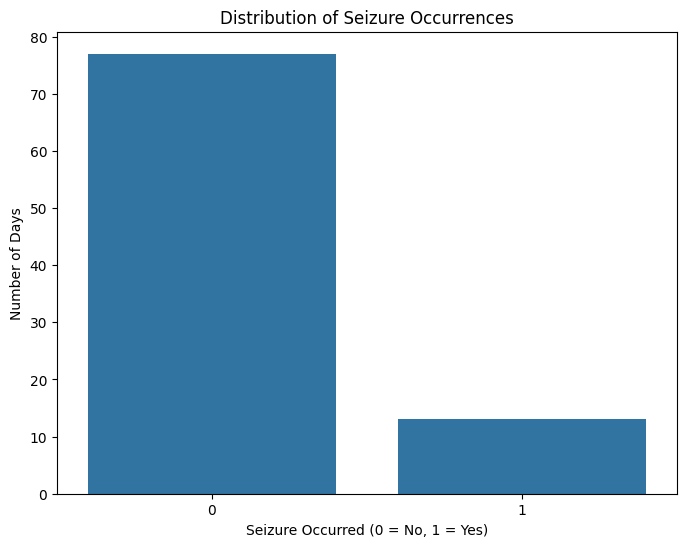

In [2]:
# --- Visualize the distribution of our target variable ---
plt.figure(figsize=(8, 6))
sns.countplot(x='seizure_occurred', data=df)
plt.title('Distribution of Seizure Occurrences')
plt.xlabel('Seizure Occurred (0 = No, 1 = Yes)')
plt.ylabel('Number of Days')
plt.show()

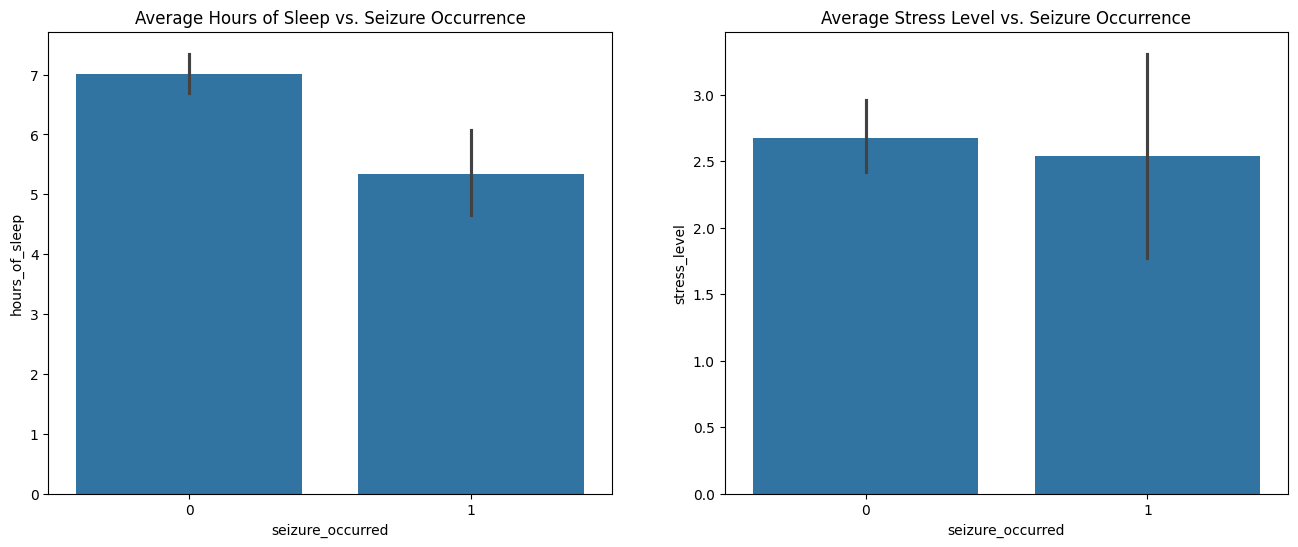

In [3]:
# --- Compare feature values for seizure vs. non-seizure days ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(ax=axes[0], x='seizure_occurred', y='hours_of_sleep', data=df)
axes[0].set_title('Average Hours of Sleep vs. Seizure Occurrence')

sns.barplot(ax=axes[1], x='seizure_occurred', y='stress_level', data=df)
axes[1].set_title('Average Stress Level vs. Seizure Occurrence')

plt.show()

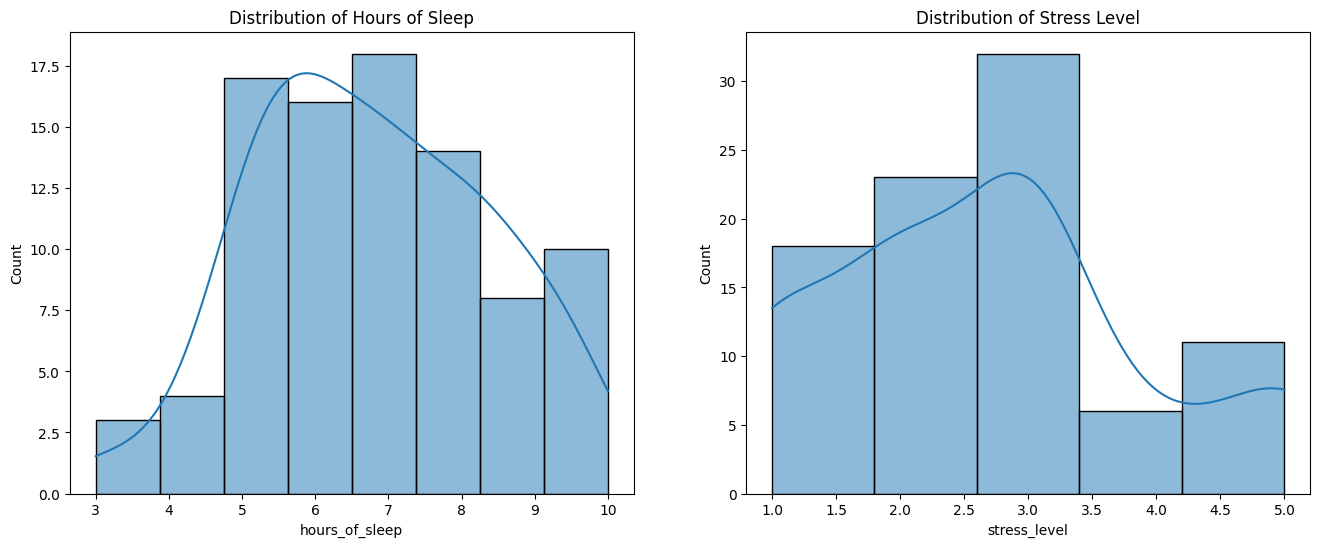

In [4]:
# --- Plot histograms for key numerical features ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['hours_of_sleep'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Hours of Sleep')

sns.histplot(df['stress_level'], kde=True, ax=axes[1], bins=5)
axes[1].set_title('Distribution of Stress Level')

plt.show()

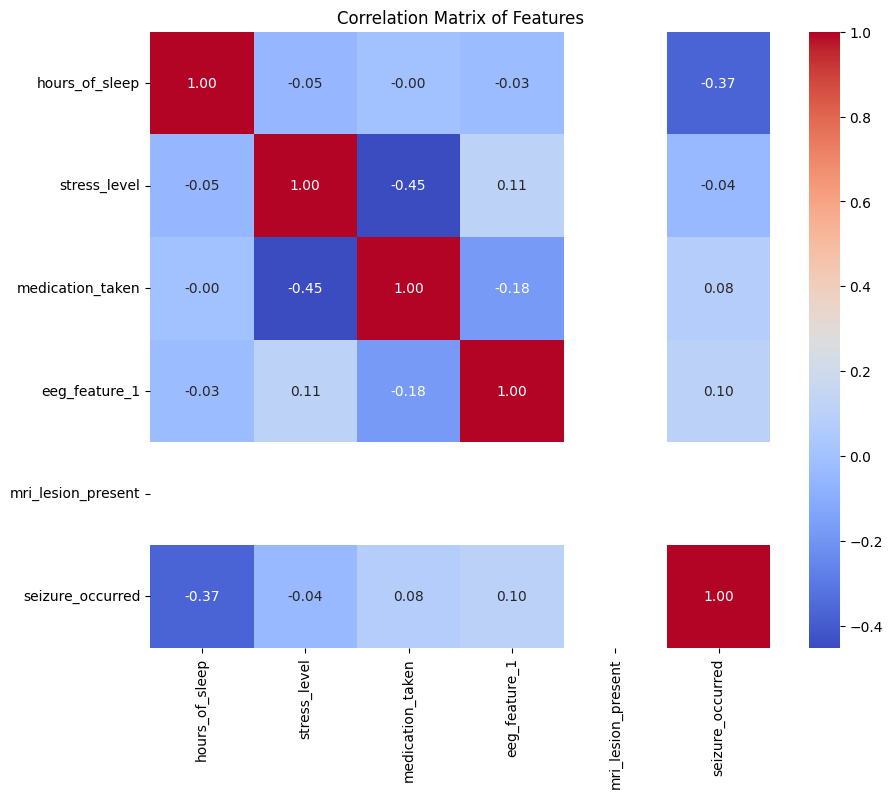

In [5]:
# --- Calculate and visualize the correlation matrix ---
# First, ensure 'date' is not included in the correlation calculation
numerical_df = df.drop(columns=['date', 'patient_id'])

plt.figure(figsize=(10, 8))
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

In [6]:
# --- Make a copy to preserve the original dataframe ---
df_feat = df.copy()

# --- Ensure 'date' is a datetime object and set it as the index ---
df_feat['date'] = pd.to_datetime(df_feat['date'])
df_feat = df_feat.set_index('date')

# --- 1. Create Lag Features ---
# Lag features provide the model with a "memory" of the recent past.
# We'll create features for the previous day's values.
df_feat['sleep_lag_1'] = df_feat['hours_of_sleep'].shift(1)
df_feat['stress_lag_1'] = df_feat['stress_level'].shift(1)
df_feat['medication_lag_1'] = df_feat['medication_taken'].shift(1)
df_feat['eeg_lag_1'] = df_feat['eeg_feature_1'].shift(1)

# --- 2. Create Rolling Window Features ---
# Rolling features capture trends over a period, smoothing out daily noise.
# We'll create 3-day and 7-day rolling averages.
df_feat['sleep_rolling_avg_3'] = df_feat['hours_of_sleep'].rolling(window=3).mean()
df_feat['stress_rolling_avg_3'] = df_feat['stress_level'].rolling(window=3).mean()

df_feat['sleep_rolling_avg_7'] = df_feat['hours_of_sleep'].rolling(window=7).mean()
df_feat['stress_rolling_avg_7'] = df_feat['stress_level'].rolling(window=7).mean()


# --- 3. Handle Missing Values ---
# The shift() and rolling() operations create NaN (Not a Number) values
# at the beginning of the dataset where there is no prior data.
# We will drop these rows as they cannot be used for training.
df_feat = df_feat.dropna()

print("Shape of the new feature DataFrame:", df_feat.shape)
print("New features have been created.")
df_feat.head(10)

Shape of the new feature DataFrame: (84, 15)
New features have been created.


,patient_id,hours_of_sleep,stress_level,medication_taken,eeg_feature_1,mri_lesion_present,seizure_occurred,sleep_lag_1,stress_lag_1,medication_lag_1,eeg_lag_1,sleep_rolling_avg_3,stress_rolling_avg_3,sleep_rolling_avg_7,stress_rolling_avg_7
date,,,,,,,,,,,,,,,
2025-09-07,1,4.6,5,0,120.23,1,0,3.0,4.0,1.0,106.02,5.000000,3.666667,5.842857,2.857143
2025-09-08,1,8.0,2,1,72.55,1,0,4.6,5.0,0.0,120.23,5.200000,3.666667,6.128571,2.857143
2025-09-09,1,8.9,1,1,132.79,1,0,8.0,2.0,1.0,72.55,7.166667,2.666667,6.342857,2.857143
2025-09-10,1,6.5,2,1,107.51,1,0,8.9,1.0,1.0,132.79,7.800000,1.666667,6.257143,2.714286
2025-09-11,1,3.8,1,1,128.74,1,1,6.5,2.0,1.0,107.51,6.400000,1.333333,6.028571,2.428571
2025-09-12,1,5.4,2,1,94.59,1,0,3.8,1.0,1.0,128.74,5.233333,1.666667,5.742857,2.428571
2025-09-13,1,9.2,3,0,131.04,1,0,5.4,2.0,1.0,94.59,6.133333,2.000000,6.628571,2.285714
2025-09-14,1,5.1,3,1,69.54,1,0,9.2,3.0,0.0,131.04,6.566667,2.666667,6.700000,2.000000
2025-09-15,1,5.0,2,1,105.92,1,1,5.1,3.0,1.0,69.54,6.433333,2.666667,6.271429,2.000000


In [7]:
# --- Save the feature-engineered data to a new CSV file ---
processed_path = '../data/processed/featured_patient_data.csv'
df_feat.to_csv(processed_path)

print(f"Successfully saved feature-engineered data to '{processed_path}'")

Successfully saved feature-engineered data to '../data/processed/featured_patient_data.csv'
